In [41]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import altair as alt
import time
import sklearn
import warnings
import pickle

warnings.filterwarnings(action='ignore', category=FutureWarning)

pd.__version__, sklearn.__version__

('2.1.1', '1.3.1')

In [42]:
SCRATCH_DIR = "/scratch/siads696f23_class_root/siads696f23_class/psollars"

# For local dev
SCRATCH_DIR = "./../data"

In [43]:
start_time = time.time()
all_features_2019 = pd.read_parquet(f"{SCRATCH_DIR}/all_features_2019.parquet")
all_features_2019 = all_features_2019[
    all_features_2019["Cancelled"].eq(0) & all_features_2019["Diverted"].eq(0)
]
end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 83.7818 seconds


In [44]:
# Feature selection from "feature_selection_2019_UA-for-real.ipynb"

num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "DistanceGroup",
    "YEAR MFR",
    "HORSEPOWER",
    "THRUST",
    "NO-SEATS",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    # # Remove based on the intuition that a particular day may have extremely bad weather causing many delays,
    # this guarantees overfitting to the data since this day will never happen again, it doesn't reveal a trend.
    #     "FlightDate",
    "Reporting_Airline",  # we need this to filter out the dataset later
    "Tail_Number",
    "Origin",
    "Dest",
    # "DestCityMarketID", # This is a duplication of origin and dest, which we may filter out anyway later
    # "N-NUMBER",  # Duplication of Tail_Number, we only need a single way to identify the aircraft
    # "MFR MDL CODE", # This is a joining column, duplicate of aircraft manufacturer
    # "ENG MFR MDL", # Code for engine model
    "TYPE REGISTRANT", # Corporations and LLCs
    "NAME",
    "CERTIFICATION", 
    "TYPE ENGINE",
    "STATUS CODE",
    # "MODE S CODE", These identify the aircraft uniquely, we can use tail number
    # "MODE S CODE HEX",
    # "CODE", # Duplicate of the engine model
    "MFR", # Engine manufacturer, condense this
    "MODEL", # Engine model
    "TYPE", # 5 - Fixed wing multi engine
    # "CODE_aircraft", Duplicate of the aircraft manufacturer
    "MFR_aircraft",
    "MODEL_aircraft",
    # "TYPE-ENG", # duplicate
    "BUILD-CERT-IND", # 0 only, we don't care about kit built aircraft
    # "faa_registration_origin", # Tracking column, may be related to registration status
    "Origin_DISPLAY_AIRPORT_NAME",
    "Origin_DISPLAY_AIRPORT_CITY_NAME_FULL",
    "Dest_DISPLAY_AIRPORT_NAME",
    "Dest_DISPLAY_AIRPORT_CITY_NAME_FULL",
]

In [46]:
delay_cols = [
    "DepDel15",
    "ArrDel15",
    "CarrierDelay",
    "WeatherDelay",
    "NASDelay",
    "SecurityDelay",
    "LateAircraftDelay",
]

# Add delay columns so we can filter later
consolidated_df = all_features_2019[num_cols + cat_cols + delay_cols].copy()

# Identify problematic columns
# for col in consolidated_df.columns:
#     try:
#         consolidated_df[col].astype(float)
#     except ValueError:
#         print(f"Column {col} contains non-convertible values.")

cols_to_convert = [
    "YEAR MFR",
    "TYPE REGISTRANT",
    "TYPE",
    "TYPE ENGINE",
    "BUILD-CERT-IND",
]

for col in cols_to_convert:
    try:
        consolidated_df[col] = pd.to_numeric(
            consolidated_df[col].str.strip(), errors="coerce"
        )
    except:
        print(col, "isn't a string")
        consolidated_df[col] = consolidated_df[col].astype("float")

# Clean up some of the weird, non-commercial aircraft registrations
consolidated_df = consolidated_df[
    (  # 7 or 3
        consolidated_df["TYPE REGISTRANT"].eq(7)
        | consolidated_df["TYPE REGISTRANT"].eq(3)
    )
    & (  # 4 or 5
        consolidated_df["TYPE"].eq(4) | consolidated_df["TYPE"].eq(5)
    )  # 4 or 5
    & (consolidated_df["TYPE ENGINE"].eq(4) | consolidated_df["TYPE ENGINE"].eq(5))
    & consolidated_df["BUILD-CERT-IND"].eq(0)  # 0 only
]

print(consolidated_df.value_counts("TYPE REGISTRANT"))

consolidated_df
# 6997303 rows × 44 columns

BUILD-CERT-IND isn't a string
TYPE REGISTRANT
3.0    6831815
7.0     165488
Name: count, dtype: int64


,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,DistanceGroup,YEAR MFR,...,Origin_DISPLAY_AIRPORT_CITY_NAME_FULL,Dest_DISPLAY_AIRPORT_NAME,Dest_DISPLAY_AIRPORT_CITY_NAME_FULL,DepDel15,ArrDel15,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
24733033,1,1,4,5,1400,1510,70,190,1,2003.0,...,"San Luis Obispo, CA",San Francisco International,"San Francisco, CA",0,0,0,0,0,0,0
24733034,1,1,4,5,0935,1118,103,438,2,2002.0,...,"Houston, TX",Northwest Arkansas National,"Fayetteville, AR",0,0,0,0,0,0,0
24733035,1,1,4,5,0643,0855,132,513,3,2002.0,...,"Springfield, MO",George Bush Intercontinental/Houston,"Houston, TX",0,0,0,0,0,0,0
24733036,1,1,4,5,1335,1433,118,576,3,2002.0,...,"Williston, ND",Denver International,"Denver, CO",0,0,0,0,0,0,0
24733037,1,1,4,5,0836,1040,184,896,4,2014.0,...,"Milwaukee, WI",Denver International,"Denver, CO",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32288695,4,12,1,7,0600,0802,122,762,4,2018.0,...,"Atlanta, GA",LaGuardia,"New York, NY",0,0,0,0,0,0,0
32288696,4,12,1,7,1209,1438,209,1310,6,1999.0,...,"Orlando, FL",Minneapolis-St Paul International,"Minneapolis, MN",1,1,0,0,0,0,23
32288697,4,12,1,7,0650,1110,200,1310,6,1999.0,...,"Minneapolis, MN",Orlando International,"Orlando, FL",0,1,0,0,36,0,0
32288698,4,12,1,7,1639,1932,293,1851,8,2000.0,...,"Washington, DC",Salt Lake City International,"Salt Lake City, UT",0,0,0,0,0,0,0


In [47]:
# BOEING                            2831659
# BOMBARDIER INC                    1262314
# AIRBUS                            1109980
# EMBRAER                            545175
# AIRBUS INDUSTRIE                   544195
# EMBRAER S A                        502448
# MCDONNELL DOUGLAS AIRCRAFT CO      103413
# EMBRAER-EMPRESA BRASILEIRA DE       83212
# MCDONNELL DOUGLAS                   64522
# AIRBUS SAS                          35971
# MCDONNELL DOUGLAS CORPORATION       25896
# C SERIES AIRCRAFT LTD PTNRSP         9258
# AIRBUS CANADA LTD PTNRSP             6573
# CANADAIR                             1948
# GULFSTREAM AEROSPACE CORP             229
# PILATUS AIRCRAFT LTD                   76
# DASSAULT                               75
# GULFSTREAM AEROSPACE                   72
# CESSNA                                 70

consolidated_df["MFR_aircraft"] = (
    consolidated_df["MFR_aircraft"]
    .replace(r".*AIRBUS.*", "AIRBUS", regex=True)
    .replace(r".*EMBRAER.*", "EMBRAER", regex=True)
    .replace(r".*MCDONNELL DOUGLAS.*", "MCDONNELL DOUGLAS", regex=True)
    .replace(r".*YABORA.*", "YABORA", regex=True)
)

mfr_aircraft_replacements = {
    "C SERIES AIRCRAFT LTD PTNRSP": "other",
    "CANADAIR": "other",
    "GULFSTREAM AEROSPACE CORP": "other",
    "PILATUS AIRCRAFT LTD": "other",
    "DASSAULT": "other",
    "GULFSTREAM AEROSPACE": "other",
    "CESSNA": "other",
}

consolidated_df["MFR_aircraft"] = (
    consolidated_df["MFR_aircraft"].str.strip().replace(mfr_aircraft_replacements)
)

consolidated_df.value_counts("MFR_aircraft")

MFR_aircraft
BOEING               2788233
AIRBUS               1675977
BOMBARDIER INC       1229884
EMBRAER              1099758
MCDONNELL DOUGLAS     191941
other                  11510
Name: count, dtype: int64

In [48]:
# CERTIFICATION
# 1T            7086132
# 41              10924
# 1N              10000
# 1                8931
# 1A               4097
# 410              2977
# 40               2397
# 4103             1482
# 1C                 76
# 1NU                70

certification_replacements = {
    "41": "other",
    "1N": "other",
    "1": "other",
    "1A": "other",
    "410": "other",
    "40": "other",
    "4103": "other",
    "1C": "other",
    "1NU": "other",
}

consolidated_df["CERTIFICATION"] = (
    consolidated_df["CERTIFICATION"].str.strip().replace(certification_replacements)
)

consolidated_df.value_counts("CERTIFICATION")

CERTIFICATION
1T       6956983
other      40320
Name: count, dtype: int64

In [49]:
# STATUS CODE
# V     7087375
# 25      31022
# 26       5074
# 28       2099
# 27       1516

status_code_replacements = {
    "25": "other",
    "26": "other",
    "28": "other",
    "27": "other",
}

consolidated_df["STATUS CODE"] = (
    consolidated_df["STATUS CODE"].str.strip().replace(status_code_replacements)
)

consolidated_df.value_counts("STATUS CODE")

STATUS CODE
V        6958080
other      39223
Name: count, dtype: int64

In [50]:
# MFR
# GE            2195782
# CFM INTL      2055793
# CFM INTL.     1165502
# IAE            960007
# ROLLS-ROYC     421279
# ROLLS DEUT      19537
# ROLLS-ROY          10
# P & W          287551
# P&W             20128
# P&W CANADA         70
# IVCHENKO         1276
# WILLIAMS           76
# HONEYWELL          75

mfr_replacements = {
    "CFM INTL.": "CFM INTL",
    "ROLLS-ROYC": "ROLLS-ROYCE",
    "ROLLS DEUT": "ROLLS-ROYCE",
    "ROLLS-ROY": "ROLLS-ROYCE",
    "P&W": "P & W",
    "P&W CANADA": "P & W",
    "IVCHENKO": "other",
    "WILLIAMS": "other",
    "HONEYWELL": "other",
}

consolidated_df["MFR"] = consolidated_df["MFR"].str.strip().replace(mfr_replacements)

consolidated_df.value_counts("MFR")

MFR
CFM INTL       3172698
GE             2142370
IAE             946452
ROLLS-ROYCE     428975
P & W           305393
other             1415
Name: count, dtype: int64

In [51]:
# Checkpoint

# consolidated_df.to_parquet(f"{SCRATCH_DIR}/consolidated_features_all_delays.parquet")

consolidated_df = pd.read_parquet(f"{SCRATCH_DIR}/consolidated_features_all_delays.parquet")

In [62]:
num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "DistanceGroup",
    "YEAR MFR",
    "HORSEPOWER",
    "THRUST",
    "NO-SEATS",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    "Reporting_Airline",
    "Tail_Number",
    "Origin",
    "Dest",
    "TYPE REGISTRANT",
    "NAME",
    "CERTIFICATION",
    "TYPE ENGINE",
    "STATUS CODE",
    "MFR",
    "MODEL",
    "TYPE",
    "MFR_aircraft",
    "MODEL_aircraft",
    "BUILD-CERT-IND",
    #
    # Labels only, duplicates of the airport coordinates, also Origin/Dest
    # "Origin_DISPLAY_AIRPORT_NAME",
    # "Origin_DISPLAY_AIRPORT_CITY_NAME_FULL",
    # "Dest_DISPLAY_AIRPORT_NAME",
    # "Dest_DISPLAY_AIRPORT_CITY_NAME_FULL",
    #
    # Only concerned with CarrierDelay for this round
    # "DepDel15",
    # "ArrDel15",
    # "CarrierDelay",
    # "WeatherDelay",
    # "NASDelay",
    # "SecurityDelay",
    # "LateAircraftDelay",
]

In [63]:
united_df = consolidated_df[num_cols + cat_cols + ["DepDel15", "ArrDel15"]].copy()

united_df = united_df[united_df["Reporting_Airline"].eq("UA")]
united_df = united_df[united_df["Origin"].eq("ORD") | united_df["Dest"].eq("ORD")]

# Convert this to "delayed"
united_df["delayed"] = (united_df["DepDel15"].eq(1)) | (united_df["ArrDel15"].eq(1))
united_df = united_df.drop(["DepDel15", "ArrDel15"], axis=1)

# Drop NaNs
united_df = united_df.dropna(how="any", axis="index")

# Drop any features that have all identical values
nunique = united_df.nunique()
united_df = united_df.drop(nunique[nunique.eq(1)].index, axis=1)
united_df["TYPE ENGINE"] = united_df["TYPE ENGINE"].astype(int)
united_df["TYPE"] = united_df["TYPE"].astype(int)

print(united_df.columns)
print(united_df.value_counts("delayed"))
# delayed
# False    592267
# True      28434

united_df
# 620701 rows × 31 columns

Index(['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime',
       'CRSArrTime', 'CRSElapsedTime', 'Distance', 'DistanceGroup', 'YEAR MFR',
       'HORSEPOWER', 'THRUST', 'NO-SEATS', 'Origin_LATITUDE',
       'Origin_LONGITUDE', 'Dest_LATITUDE', 'Dest_LONGITUDE', 'Tail_Number',
       'Origin', 'Dest', 'NAME', 'CERTIFICATION', 'TYPE ENGINE', 'MFR',
       'MODEL', 'TYPE', 'MFR_aircraft', 'MODEL_aircraft', 'delayed'],
      dtype='object')
delayed
False    114157
True      39403
Name: count, dtype: int64


,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,DistanceGroup,YEAR MFR,...,Dest,NAME,CERTIFICATION,TYPE ENGINE,MFR,MODEL,TYPE,MFR_aircraft,MODEL_aircraft,delayed
25272188,1,1,22,2,1315,1932,257,1846,8,2001.0,...,ORD,WELLS FARGO TRUST CO NA TRUSTEE ...,1T,5,ROLLS-ROYCE,RB-211 SERIES,5,BOEING,757-33N,True
25272196,1,1,22,2,1000,1144,164,733,3,2002.0,...,ORD,UNITED AIRLINES INC ...,1T,5,CFM INTL,CFM56-7B22,5,BOEING,737-700,False
25272197,1,1,22,2,1430,1650,80,296,2,2015.0,...,CMH,UNITED AIRLINES INC ...,1T,5,CFM INTL,CFM56-7B27E,5,BOEING,737-924ER,True
25272202,1,1,22,2,1011,1200,169,888,4,2004.0,...,DEN,UNITED AIRLINES INC ...,1T,5,ROLLS-ROYCE,RB-211 SERIES,5,BOEING,757-324,True
25272222,1,1,22,2,1423,2024,241,1723,7,2004.0,...,ORD,UMB BANK NA TRUSTEE ...,1T,5,CFM INTL,CFM56 SERIES,5,BOEING,737-824,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32219984,4,12,28,6,1747,2014,207,1197,5,1994.0,...,ORD,U S BANK NA TRUSTEE ...,1T,5,IAE,V2500SERIES,4,AIRBUS,A320-232,True
32219989,4,12,28,6,0755,1049,174,925,4,2014.0,...,IAH,UNITED AIRLINES INC ...,1T,5,CFM INTL,CFM56-7B27E,5,BOEING,737-924ER,False
32219991,4,12,28,6,2324,0510,226,1739,7,1999.0,...,ORD,UNITED AIRLINES INC ...,1T,5,CFM INTL,CFM56 SERIES,5,BOEING,737-824,False
32219994,4,12,28,6,0745,1145,180,1120,5,2008.0,...,RSW,UNITED AIRLINES INC ...,1T,5,CFM INTL,CFM56-7B26,5,BOEING,737-924ER,False


In [64]:
# Define features one last time now that the identical values have been removed

num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "DistanceGroup",
    "YEAR MFR",
    "HORSEPOWER",
    "THRUST",
    "NO-SEATS",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    "Tail_Number",
    "Origin",
    "Dest",
    "NAME",
    "CERTIFICATION",
    "TYPE ENGINE",
    # "STATUS CODE",
    "MFR",
    "MODEL",
    "TYPE",
    "MFR_aircraft",
    "MODEL_aircraft",
]

In [37]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

start_time = time.time()

X = united_df.drop("delayed", axis=1)
y = united_df["delayed"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        # ("cat", OneHotEncoder(), cat_cols),
        ("cat", OrdinalEncoder(), cat_cols),
    ]
)

X_transformed = preprocessor.fit_transform(X)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 1.1927 seconds


In [38]:
from sklearn.model_selection import train_test_split

start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42
)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 0.0348 seconds


In [39]:
from imblearn.over_sampling import SMOTE

start_time = time.time()

smote = SMOTE(sampling_strategy="auto", random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

X_res.shape, y_res.shape
# ((234740, 29), (234740,))

Elapsed time: 2.2478 seconds


((182596, 28), (182596,))

In [40]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_res, y_res)

feature_names = num_cols + list(
    preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
)

coefficients = ridge.coef_

feature_importance = list(zip(feature_names, coefficients))

sorted_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

sorted_features

# [('CRSElapsedTime', 0.1913630084161205),
#  ('Distance', -0.17271829173646355),
#  ('CERTIFICATION', -0.08112736724506671),
#  ('MFR_aircraft', 0.07184517410126441),
#  ('CRSDepTime', 0.06256133411426514),
#  ('CRSArrTime', 0.05205773625769361),
#  ('Quarter', -0.037420251981028205),
#  ('DayofMonth', 0.03578167719194388),
#  ('Origin_LATITUDE', 0.021165410300762473),
#  ('YEAR MFR', -0.02041835738783485),

[('CRSElapsedTime', 0.19140441893492183),
 ('Distance', -0.1726494284452512),
 ('MFR_aircraft', 0.07079228292554188),
 ('CRSDepTime', 0.06253404815031834),
 ('CRSArrTime', 0.05205964432792805),
 ('Quarter', -0.03744975270284179),
 ('DayofMonth', 0.035763566079918284),
 ('Origin_LATITUDE', 0.021180059706512478),
 ('YEAR MFR', -0.020647048365868777),
 ('NO-SEATS', 0.018006895530590202),
 ('TYPE', 0.01633997467048872),
 ('Dest_LONGITUDE', 0.016030447003447378),
 ('Dest_LATITUDE', 0.010078945934366703),
 ('DistanceGroup', -0.005746517558439401),
 ('MODEL_aircraft', 0.0056283425370541144),
 ('TYPE-ENG', -0.005441320490977417),
 ('TYPE ENGINE', -0.00544131982562808),
 ('NAME', 0.00542816561116938),
 ('HORSEPOWER', 0.004062411889467443),
 ('MFR', 0.003713950468693596),
 ('Month', 0.0031889839121881204),
 ('Origin_LONGITUDE', 0.0024102454796192316),
 ('THRUST', 0.0023573055496247963),
 ('DayOfWeek', -0.0009505132740527959),
 ('MODEL', -0.000675026279007127),
 ('Origin', 0.0005028750610861235),

In [12]:
from sklearn.linear_model import Lasso

start_time = time.time()

lasso = Lasso(alpha=0.1)
lasso.fit(X_res, y_res)

feature_names = num_cols + list(
    preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
)

important_features = np.nonzero(lasso.coef_)[0]
important_feature_names = [feature_names[i] for i in important_features]


end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

important_feature_names  # :(
# ['Tail_Number', 'MODEL']

Elapsed time: 0.1458 seconds


['CRSDepTime', 'CRSArrTime', 'Tail_Number', 'Origin', 'Dest', 'MODEL']

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


def fit_grid_search_logistic_regression(fit_X_train, fit_y_train):
    grid_search = GridSearchCV(
        LogisticRegression(solver="saga", max_iter=1000),
        param_grid={},
        scoring="f1",
        verbose=3,
        cv=5,
        n_jobs=-1,
    )

    grid_search.fit(fit_X_train, fit_y_train)

    return grid_search


start_time = time.time()

model = fit_grid_search_logistic_regression(X_res, y_res)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

In [ ]:
# Checkpoint

LOGISTIC_REGRESSION_MODEL = "16_UA_carrier_delays_logistic_regression.pkl"

with open(f"{SCRATCH_DIR}/{LOGISTIC_REGRESSION_MODEL}", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/{LOGISTIC_REGRESSION_MODEL}", "rb") as f:
#     model = pickle.load(f)

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
import xgboost as xgb


def fit_grid_search_xg_boost(fit_X_train, fit_y_train):
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=recall_score,
        scale_pos_weight=sum(fit_y_train == 0) / sum(fit_y_train == 1),
    )

    grid_search = GridSearchCV(
        estimator=xgb_clf,
        param_grid={
            "learning_rate": [0.01, 0.1, 0.2, 0.3],
            # "max_depth": [5, 7, 10],
            # "n_estimators": [150],  # , 250, 500],
            # "subsample": [0.6, 0.7, 0.8],
            # "colsample_bytree": [0.6, 0.7, 0.8],
        },
        scoring="recall",
        verbose=3,
        cv=5,
        n_jobs=-1,
    )

    grid_search.fit(fit_X_train, fit_y_train)

    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

    return grid_search


start_time = time.time()

model = fit_grid_search_xg_boost(X_res, y_res)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if i

[CV 1/5] END .................learning_rate=0.1;, score=0.459 total time=   7.6s
[CV 3/5] END .................learning_rate=0.1;, score=0.975 total time=   7.8s
[CV 2/5] END .................learning_rate=0.1;, score=0.970 total time=   7.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END ................learning_rate=0.01;, score=0.876 total time=   8.2s
[CV 5/5] END ................learning_rate=0.01;, score=0.876 total time=   8.2s
[CV 3/5] END ................learning_rate=0.01;, score=0.865 total time=   8.2s
[CV 2/5] END ................learning_rate=0.01;, score=0.859 total time=   8.2s
[CV 1/5] END ................learning_rate=0.01;, score=0.509 total time=   8.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if i

[CV 1/5] END .................learning_rate=0.2;, score=0.467 total time=   7.2s
[CV 4/5] END .................learning_rate=0.1;, score=0.971 total time=   7.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END .................learning_rate=0.3;, score=0.471 total time=   7.2s
[CV 5/5] END .................learning_rate=0.1;, score=0.977 total time=   7.7s
[CV 2/5] END .................learning_rate=0.2;, score=0.983 total time=   7.4s
[CV 4/5] END .................learning_rate=0.2;, score=0.983 total time=   7.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END .................learning_rate=0.2;, score=0.987 total time=   7.5s
[CV 3/5] END .................learning_rate=0.2;, score=0.984 total time=   7.6s
[CV 2/5] END .................learning_rate=0.3;, score=0.989 total time=   4.8s
[CV 3/5] END .................learning_rate=0.3;, score=0.989 total time=   4.8s
[CV 5/5] END .................learning_rate=0.3;, score=0.991 total time=   4.8s
[CV 4/5] END .................learning_rate=0.3;, score=0.988 total time=   4.9s
Best parameters:  {'learning_rate': 0.3}
Best score:  0.8858284723219201
Elapsed time: 25.6255 seconds


In [28]:
# Checkpoint

XGBOOST_MODEL = "16_ORD_UA_all_delays_xgboost.pkl"

with open(f"{SCRATCH_DIR}/{XGBOOST_MODEL}", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/{XGBOOST_MODEL}", "rb") as f:
#     model = pickle.load(f)

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


def fit_grid_search_random_forest(fit_X_train, fit_y_train):
    rf_clf = RandomForestClassifier(class_weight="balanced", random_state=42)

    grid_search = GridSearchCV(
        estimator=rf_clf,
        param_grid={
            "n_estimators": [100],  # [50, 100, 150],
            "max_depth": [None],  # , 10, 20, 30],
            "min_samples_split": [2],  #  5, 10],
            "min_samples_leaf": [1],  #  2, 4],
        },
        scoring="f1",
        verbose=3,
        cv=5,
        n_jobs=-1,
    )
    
    grid_search.fit(fit_X_train, fit_y_train)

    return grid_search


start_time = time.time()

model = fit_grid_search_random_forest(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.298 total time=  39.7s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.301 total time=  40.0s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.295 total time=  40.4s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.301 total time=  39.5s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.308 total time=  39.6s
Elapsed time: 67.5186 seconds


In [31]:
# Checkpoint

RANDOM_FOREST_MODEL = "16_ORD_UA_all_delays_random_forest.pkl"

with open(f"{SCRATCH_DIR}/{RANDOM_FOREST_MODEL}", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/{RANDOM_FOREST_MODEL}", "rb") as f:
#     model = pickle.load(f)

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


def fit_grid_search_svm(fit_X_train, fit_y_train):
    grid_search = GridSearchCV(
        estimator=SVC(probability=True),
        param_grid={
            # "C": [0.1, 1, 10],
            # "kernel": ["linear", "rbf"],
            # "gamma": ["auto", "scale"],
        },
        scoring="f1",
        verbose=3,
        cv=5,
        n_jobs=-1,
    )

    grid_search.fit(fit_X_train, fit_y_train)

    print("Best SVM parameters: ", grid_search.best_params_)
    print("Best SVM score: ", grid_search.best_score_)

    return grid_search


start_time = time.time()

model = fit_grid_search_svm(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 3/5] END ..................................., score=0.000 total time= 2.3min
[CV 5/5] END ..................................., score=0.000 total time= 2.4min
[CV 1/5] END ..................................., score=0.000 total time= 2.3min
[CV 4/5] END ..................................., score=0.000 total time= 2.4min
[CV 2/5] END ..................................., score=0.000 total time= 2.4min
Best SVM parameters:  {}
Best SVM score:  0.0
Elapsed time: 233.2491 seconds


In [ ]:
# Checkpoint

SVM_MODEL = "16_ORD_UA_all_delays_svm.pkl"

with open(f"{SCRATCH_DIR}/{SVM_MODEL}", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/{SVM_MODEL}", "rb") as f:
#     model = pickle.load(f)

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier


def fit_grid_search_gradient_boost(fit_X_train, fit_y_train):
    grid_search = GridSearchCV(
        estimator=HistGradientBoostingClassifier(),
        param_grid={
            "learning_rate": [0.001, 0.1, 0.5],
            "max_iter": [100],  # [50, 100, 200],
            "max_depth": [None],  # [None, 10, 20],
            "min_samples_leaf": [40],  # [20, 40, 60],
            "l2_regularization": [0.0, 2.0, 3.0, 5.0],
        },
        scoring="recall",
        verbose=3,
        cv=5,
        n_jobs=-1,
    )

    grid_search.fit(fit_X_train, fit_y_train)

    print("Best HistGradientBoosting parameters: ", grid_search.best_params_)
    print("Best HistGradientBoosting score: ", grid_search.best_score_)

    return grid_search


start_time = time.time()

model = fit_grid_search_gradient_boost(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END l2_regularization=0.0, learning_rate=0.1, max_depth=None, max_iter=100, min_samples_leaf=40;, score=0.550 total time=   6.7s
[CV 3/5] END l2_regularization=0.0, learning_rate=0.1, max_depth=None, max_iter=100, min_samples_leaf=40;, score=0.557 total time=   6.7s
[CV 2/5] END l2_regularization=0.0, learning_rate=0.1, max_depth=None, max_iter=100, min_samples_leaf=40;, score=0.562 total time=   6.8s
[CV 3/5] END l2_regularization=0.0, learning_rate=0.001, max_depth=None, max_iter=100, min_samples_leaf=40;, score=0.424 total time=   7.8s
[CV 1/5] END l2_regularization=0.0, learning_rate=0.001, max_depth=None, max_iter=100, min_samples_leaf=40;, score=0.422 total time=   8.0s
[CV 2/5] END l2_regularization=0.0, learning_rate=0.001, max_depth=None, max_iter=100, min_samples_leaf=40;, score=0.440 total time=   8.0s
[CV 5/5] END l2_regularization=0.0, learning_rate=0.001, max_depth=None, max_iter=100, min_samples_leaf=4

In [39]:
# Checkpoint

GRADIENT_BOOST_MODEL = "16_ORD_UA_all_delays_gradient_boost.pkl"

with open(f"{SCRATCH_DIR}/{GRADIENT_BOOST_MODEL}", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/{GRADIENT_BOOST_MODEL}", "rb") as f:
#     model = pickle.load(f)

In [ ]:
from imblearn.over_sampling import SMOTENC
from catboost import CatBoostClassifier


# No need to use the ordinal encoder for CatBoost, but we need to do some other preprocessing
X = united_df.drop("delayed", axis=1)
y = united_df["delayed"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cat_indices = [X.columns.get_loc(col) for col in cat_cols]

smote = SMOTENC(categorical_features=cat_cols, sampling_strategy="auto", random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)


In [83]:
from sklearn.metrics import make_scorer, fbeta_score


def fit_grid_search_cat_boost(fit_X_train, fit_y_train):
    cat_clf = CatBoostClassifier(
        eval_metric="F1",
        auto_class_weights="Balanced",
        cat_features=cat_indices,
    )

    # Attempt to increase precision
    f_beta_scorer = make_scorer(fbeta_score, beta=0.1)

    grid_search = GridSearchCV(
        estimator=cat_clf,
        param_grid={
            "learning_rate": [0.001, 0.01, 0.1, 0.2],
            "depth": [4, 6, 8],
            "iterations": [100],
            "l2_leaf_reg": [1, 3, 5],
        },
        scoring=f_beta_scorer,
        verbose=3,
        cv=5,
        n_jobs=-1,
    )

    grid_search.fit(fit_X_train, fit_y_train)

    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

    return grid_search


start_time = time.time()

model = fit_grid_search_cat_boost(X_res, y_res)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

# Best parameters:  {'depth': 10, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.2}
# Best score:  0.8449242597574239
# Elapsed time: 6379.6963 seconds

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0:	learn: 0.6558145	total: 157ms	remaining: 15.6s
0:	learn: 0.6559102	total: 241ms	remaining: 23.9s
3:	learn: 0.6567614	total: 715ms	remaining: 17.2s
0:	learn: 0.6481922	total: 261ms	remaining: 25.8s
3:	learn: 0.6391141	total: 1.05s	remaining: 25.1s
0:	learn: 0.6072036	total: 206ms	remaining: 20.4s
6:	learn: 0.6544153	total: 1.3s	remaining: 17.2s
3:	learn: 0.6412247	total: 916ms	remaining: 22s
0:	learn: 0.5858676	total: 235ms	remaining: 23.2s
6:	learn: 0.6394725	total: 1.68s	remaining: 22.4s
9:	learn: 0.6533963	total: 2.05s	remaining: 18.5s
3:	learn: 0.6201679	total: 1.07s	remaining: 25.6s
6:	learn: 0.6391777	total: 1.81s	remaining: 24s
0:	learn: 0.6558145	total: 356ms	remaining: 35.2s
3:	learn: 0.6554352	total: 1.1s	remaining: 26.3s
9:	learn: 0.6363571	total: 2.54s	remaining: 22.9s
12:	learn: 0.6531450	total: 3.07s	remaining: 20.5s
6:	learn: 0.6422765	total: 2.09s	remaining: 27.8s
9:	learn: 0.6401978	total: 2.67s	remaining:

In [89]:
# Checkpoint

CAT_BOOST_MODEL = "16_ORD_UA_all_delays_catboost_fbeta_0.1.pkl"

with open(f"{SCRATCH_DIR}/{CAT_BOOST_MODEL}", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/{CAT_BOOST_MODEL}", "rb") as f:
#     model = pickle.load(f)

# Model Evaluation

In [84]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
)

y_pred = model.predict(X_test)

# y_pred_proba = model.best_estimator_.predict_proba(X_test)

ra_score = roc_auc_score(y_test, y_pred, average="macro", multi_class="ovr")

# xgboost
# 0.803598235336136

# random forest
# 0.5041971245888275

ra_score

0.6321403754307372

[[20514  2345]
 [ 4972  2881]]


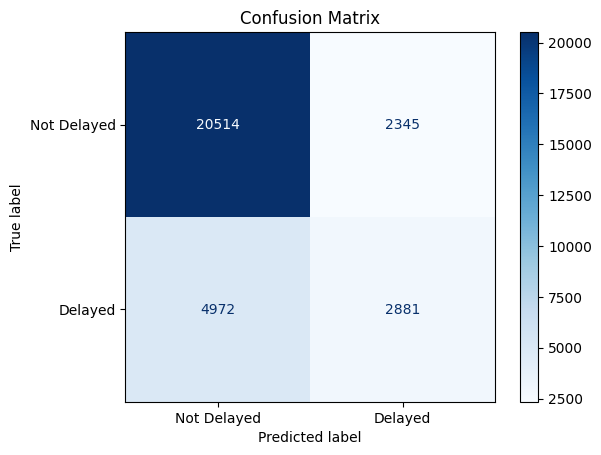

In [85]:
cm = confusion_matrix(y_test, y_pred)

print(cm)

ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Delayed", "Delayed"]
).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

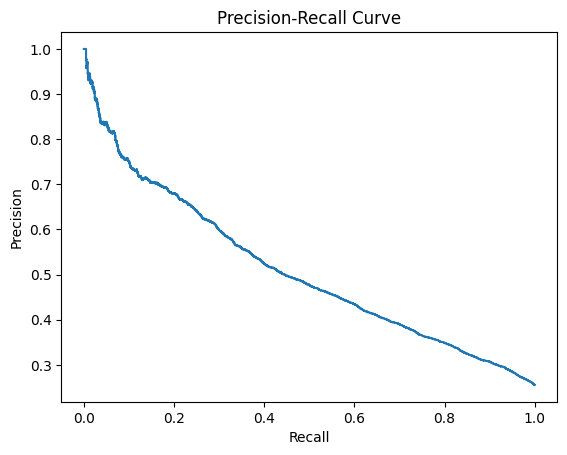

In [86]:
y_scores = model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


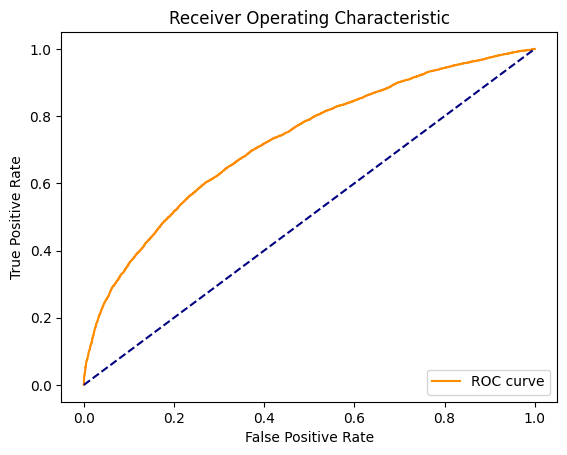

In [87]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [71]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

accuracy, precision, recall, f1

(0.6019796822089085, 0.339124033860876, 0.5866547816121228, 0.4297975557421402)

In [88]:
metrics_scores = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
}

df_metrics = pd.DataFrame(list(metrics_scores.items()), columns=["Metric", "Score"])

base = alt.Chart(df_metrics).encode(
    y=alt.Y("Metric:N", axis=alt.Axis(title="Metric")),
    x=alt.X("Score:Q", axis=alt.Axis(title="Score"), scale=alt.Scale(domain=[0, 1])),
)

bar = base.mark_bar().encode(
    color=alt.Color("Metric:N", legend=None), text=alt.Text("Score:Q", format=".2f")
)

text = base.mark_text(
    align="right",
    baseline="middle",
    color="white",
    dx=-10,
).encode(text=alt.Text("Score:Q", format=".2f"))

chart = (
    (bar + text)
    .properties(title="Evaluation Metrics", width=600, height=300)
    .configure_axis(labelFontSize=12, titleFontSize=14)
)

chart

alt.LayerChart(...)